### 시계열 분석

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#회귀분석
import statsmodels.api as sm

#날짜 데이터 생성
from datetime import datetime

#자기상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

### STEP1 데이터 구성하기

In [4]:
df_raw = pd.read_csv('/home/piai/Downloads/환율.csv', engine = 'python', parse_dates = ['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CURRENCY       273 non-null    object        
 1   APPL_DATE      273 non-null    datetime64[ns]
 2   STD_RATE       273 non-null    float64       
 3   USD_CONV_DATE  273 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 8.7+ KB


In [7]:
#pivit(index, columns, values ) 활용하여 각국의 통화별 데이터 생서
df_raw_pivot = df_raw.pivot(index = 'APPL_DATE', columns = 'CURRENCY', values = 'STD_RATE')
df_raw_pivot.head()

CURRENCY,CNY,JPY,USD
APPL_DATE,,,
2016-01-01,181.48,976.99,1178.0
2016-01-02,181.48,976.99,1178.0
2016-01-03,181.48,976.99,1178.0
2016-01-04,181.10,992.62,1184.0
2016-01-05,181.94,993.00,1185.0


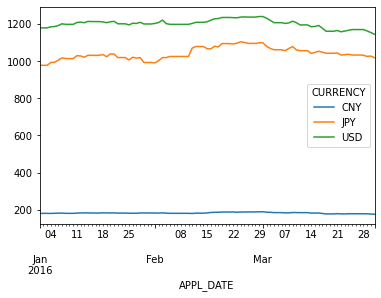

In [8]:
#중국 위안, 일본 엔화, 미국 달러 전체 그림
df_raw_pivot.plot()

### STEP2 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성


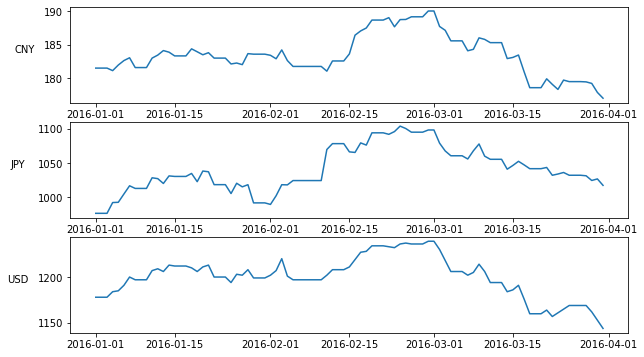

In [11]:
### 변동 추세 확인 - 시간에 따른 환율 추세 그래프 생성
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,6))
 in zip(ax1, ax2, ax3)
#zip 함수를 사용하면 zip 함수 안의 리스트들을 하나씩 출력
#311 -> 3행 1열의 1번 그래프
#1번 loop: ax1, 311, 'CNY', 2번 loop: ax2, 312, 'JPY', 3번 loop: ax3, 313, 'USD'

for (ax, idx, currency) in zip([ax1,ax2,ax3] , [311,312,313], ['CNY','JPY','USD']):
    ax.plot('APPL_DATE','STD_RATE', data = df_raw[df_raw['CURRENCY'] == currency])
    ax.set_ylabel(currency, rotation = 0 , labelpad = 20)

* 1번과 2번 구간의 평균이 다르고 변동이 달라 정상성이 만족되지 않으므로 차분이 필요!

### STEP3 시계열 분석: 데이터 분할 - 통화별 데이터 분할

In [13]:
#CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY = df_raw[df_raw['CURRENCY']=='CNY'].set_index('APPL_DATE')

df_CNY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

#CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_JPY = df_raw[df_raw['CURRENCY']=='JPY'].set_index('APPL_DATE')

df_JPY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

#CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_USD = df_raw[df_raw['CURRENCY']=='USD'].set_index('APPL_DATE')

df_USD.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [17]:
#train test 데이터 분할: 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [18]:
#mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print(f'shape of train data: {df_CNY_train.shape}')
print(f'shape of test data: {df_CNY_test.shape}')

shape of train data: (82, 1)
shape of test data: (9, 1)


In [19]:
#추가설명 : train test 데이터 분할 : index 직접 지정
df_CNY_train = df_CNY[df_CNY.index <= '2016-03-22']
df_CNY_test = df_CNY[df_CNY.index > '2016-03-22']
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


### 시계열 분석: 데이터 분할 - 차분을 통하여 정상성 데이터로 변환

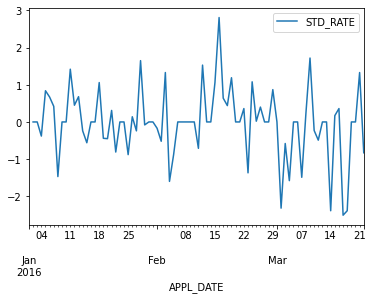

In [22]:
#1차 차분: z(t) - z(t-1)
#shift(n): 앞의 n번 째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()


* 1차분 결과는 원 데이터보다는 시간의 흐름에 영향을 덜 받지만 정상성이 만족스럽지 않음

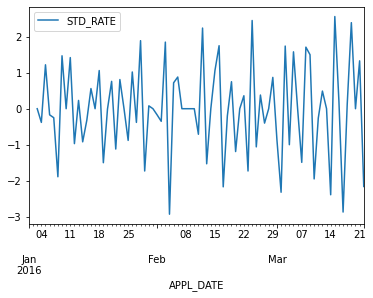

In [25]:
#2차 차분: (z(t) - z(t-1)-z(t-2)) = z(t) -2*z(t-1) -z(t-2)
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

### STEP3 시계열 분석 - 자기상관 함수 및 부분 자기상관 함수

### lag를 30까지 하여 ACF, PACF 산출

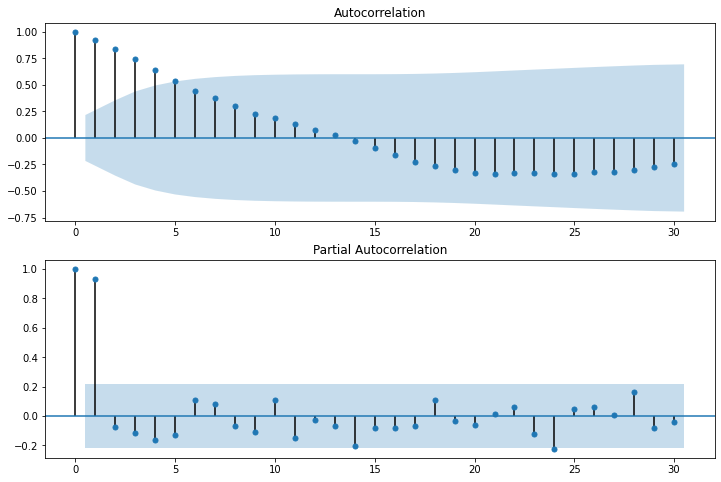

In [27]:
#AR(자기회귀) 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize = (12,8))

#acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)
#자기상관함수 그래프 : plot_acf 함수 사용
fig = plot_acf(df_CNY_train['STD_RATE'], lags = lag_size, ax= ax1)

#pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)
#부분자기상관 함수 그래프 : plot_pacf 함수 사용
fig = plot_pacf(df_CNY_train['STD_RATE'], lags = lag_size, ax= ax2)

* ACF는 지속적으로 감소하고 p =13 시점에서 양에서 음으로 볂고, PACF는 P=1 시점에서 0.9보다 크고 이후 급격히 감소(절단면)함  
* 따라서 P = 1, q = 0 모델이 적당하다고 판단 -> ARMA(1,0)

### 시계열 분석 - 시계열 모델

In [28]:
#train 데이터 이용, AR(1), I(2,차분), MA(0)인 ARIMA 모델
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0))
#데이터 적합
#trend: 상수 포함 여부 'nc'이면 상수 미포함, full_output: 모든 출력 결과 표시
ts_result_cny = ts_model_cny.fit(trend = 'c', full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Wed, 18 Nov 2020   AIC                            253.025
Time:                        17:25:48   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


* ARIMA(1,2,0) 모델의 계수 유의성 확인.   
* ar.L1.D2.STD_RATE 의 p-value 0 이므로 ARIMA(1,2,0) 모델의 계수는 유의하다.  

### STEP4 예측 및 결과 해석

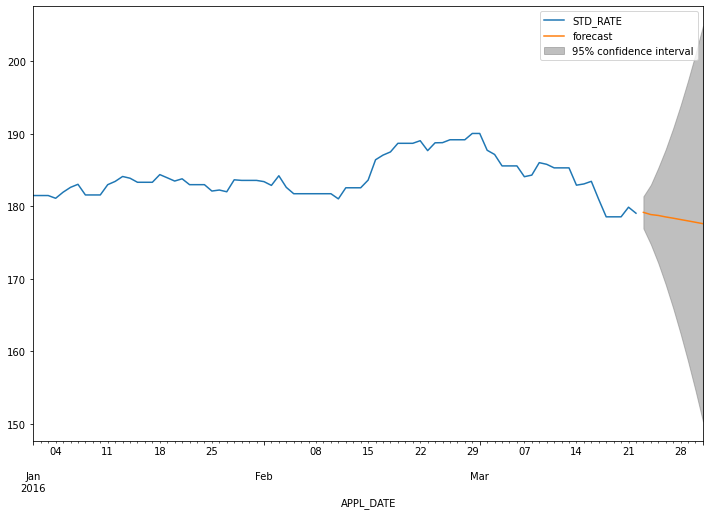

In [30]:
#예측 시작/ 종료 날짜 지정
start_time = df_CNY_test.index.min() #2016-03-23
end_time = df_CNY_test.index.max() #2016-03-31
fig, ax = plt.subplots(figsize = (12,8))

#예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)
#예측 그래프 생성 함수, start: 예측 시작, end : 예측 종료, plot_insample: 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
fig = ts_result_cny.plot_predict(start = start_time, end = end_time, ax= ax, plot_insample = False)

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWar

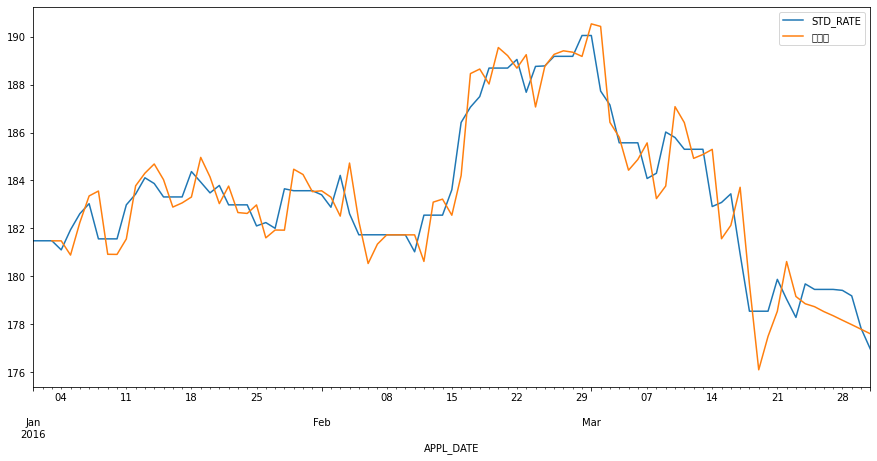

In [31]:
#전체 기간의 실제값, 예측값 확인
start_time = pd.to_datetime('2016-01-03') #차분 = 2 ->시작일자 +2 이후부터 예측값 생성됨
y_pred = ts_result_cny.predict(start= start_time, end= end_time, typ = 'levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

#추세 그래프 생성 및 확인
df_merge.plot(y=['STD_RATE', '예측값'], figsize = (15,7))

* 모델 훈련구간은 실제값 대비 지연(lag) 현상이 확인되며 예측 구간은 오차가 크다